In [9]:
import jax
jax.config.update('jax_enable_x64',True)
import jax.numpy as jnp
import pandas as pd
from jax.random import PRNGKey as pkey
from jax.scipy.special import expit
from jaxopt import LBFGS
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')
from functools import partial
from scipy.optimize import root_scalar,minimize_scalar

In [10]:
def simulate_study(
    key,
    beta_true,
    gamma_true,
    confounding_constant = 0.2,
    intercept_val = -2.,
    num_subjects_per_group = 200,
    num_groups = 4,
    num_covs = 1,
    ):
    total_subjects = num_subjects_per_group*num_groups
    num_exposures = num_groups -1
    
    keys = jax.random.split(key,10)

    assignment = jnp.vstack([jnp.arange(num_groups)]*num_subjects_per_group).T.flatten().reshape(-1,1)
    covs = jnp.hstack([jax.random.normal(keys[0],(total_subjects,num_covs))]) + confounding_constant*assignment
    beta_covs = jax.random.normal(keys[2],(num_covs,))

    beta_perturb = jnp.sqrt(gamma_true)*jax.random.normal(keys[8])

    beta_study = beta_true+beta_perturb
    full_beta = jnp.hstack([beta_study,intercept_val,beta_covs])

    #This is just for simulating
    X_sim = jnp.hstack([assignment,jnp.ones((total_subjects,1)),covs])
    Y_obs = jax.random.binomial(keys[5],1,expit(X_sim@full_beta))

    dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
    X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

    df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

    dummies = pd.get_dummies(pd.Series(assignment[:,0]),prefix='treat',drop_first=True).astype('float64')
    X_reg = jnp.hstack([jnp.ones((total_subjects,1)),covs,dummies.values])

    df_reg = pd.DataFrame(X_reg,columns = ['intercept']+['covariate']+list(dummies.columns))

    model = sm.Logit(Y_obs, df_reg)
    results = model.fit(disp = 0)
    results.summary()

    summary_df = pd.DataFrame({
        'assign':assignment[:,0],
        'is_case':Y_obs
    })
    total_non_cases = len(summary_df[summary_df['is_case']==0])
    reference_non_cases = len(summary_df[(summary_df['assign']==0)&(summary_df['is_case']==0)])
    p = reference_non_cases/total_non_cases
    total_cases = summary_df['is_case'].sum()
    z = total_non_cases/total_cases

    L = results.params[-num_exposures:].values
    V = jnp.diag(results.cov_params().values[-num_exposures:,-num_exposures:])
    Z = jnp.arange(1.,1+num_exposures).reshape(-1,1)
    X = jnp.arange(1.,1+num_exposures).reshape(-1,1)
    
    return L,results.cov_params().values[-num_exposures:,-num_exposures:],X,Z

In [11]:
logdet = jax.jit(lambda x:jnp.linalg.slogdet(x)[1])
num_exposures = 3
Z = jnp.arange(1.,1+num_exposures).reshape(-1,1)
X = jnp.arange(1.,1+num_exposures).reshape(-1,1)
ZZT = Z@Z.T

@jax.jit
def margin_like(gamma,covariance_matrices,Y,X,Z):
    ZZT = Z@Z.T
    vmats = jnp.array([ZZT*gamma + C for C in covariance_matrices])
    inv_vmats = jnp.array([jnp.linalg.inv(V) for V in vmats])
    LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
    beta = (
        jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V in inv_vmats]),axis=0))@ 
        (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y in zip(inv_vmats,Y)]),axis=0))
    )
    res_term = jnp.sum(
        jnp.array([
            (X@beta - y).T@inv_v@(X@beta-y) 
            for inv_v,y in zip(inv_vmats,Y)])
        )
    return LNV+res_term

@jax.jit
def margin_like_reml(gamma,covariance_matrices,Y,X,Z):
    ZZT = Z@Z.T
    vmats = jnp.array([ZZT*gamma + C for C in covariance_matrices])
    inv_vmats = jnp.array([jnp.linalg.inv(V) for V in vmats])
    LNV = jnp.sum(jnp.array([logdet(V) for V in vmats]))
    REML_term = jnp.sum(jnp.array([logdet(X.T@invV@X for invV in inv_vmats)]))
    beta = (
        jnp.linalg.inv(jnp.sum(jnp.array([X.T@inv_V@X for inv_V in inv_vmats]),axis=0))@ 
        (jnp.sum(jnp.array([X.T@inv_V@y for inv_V,y in zip(inv_vmats,Y)]),axis=0))
    )
    res_term = jnp.sum(
        jnp.array([
            (X@beta - y).T@inv_v@(X@beta-y) 
            for inv_v,y in zip(inv_vmats,Y)])
        )
    return LNV + res_term + REML_term


diff_margin_like = jax.jit(
    jax.grad(margin_like,argnums=0)
)

diff_reml_like = jax.jit(
    jax.grad(margin_like_reml,argnums=0)
)

vec_reml_like = (
    jax.vmap(margin_like_reml,in_axes=[0,None,None,None,None])
)

vec_margin_like = (
    jax.vmap(margin_like,in_axes=[0,None,None,None,None])
)

#Old grid search code:
# gamma_grid = jnp.logspace(-2,1.,300)
# nll_corr = vec_margin_like(gamma_grid,cov_mats,L_vals,X,Z)
# gamma_corr = gamma_grid[jnp.argmin(nll_corr)]
# nll_diag = vec_margin_like(gamma_grid,diag_cov_mats,L_vals,X,Z)
# gamma_diag = gamma_grid[jnp.argmin(nll_diag)]


def estimate_gamma(L_vals,cov_mats,X,Z):
    gamma_grid = jnp.logspace(-4,2.,20)
    try:
        gamma = root_scalar(lambda x:diff_margin_like(x,cov_mats,L_vals,X,Z),bracket = (1e-3,10.)).root
    except:
        nll = vec_margin_like(gamma_grid,cov_mats,L_vals,X,Z)
        gamma = gamma_grid[jnp.argmin(nll)]
    return gamma

def estimate_gamma_reml(L_vals,cov_mats,X,Z):
    gamma_grid = jnp.logspace(-4,2.,20)
    try:
        gamma = root_scalar(lambda x:diff_reml_like(x,cov_mats,L_vals,X,Z),bracket = (1e-3,10.)).root
    except:
        nll = vec_reml_like(gamma_grid,cov_mats,L_vals,X,Z)
        gamma = gamma_grid[jnp.argmin(nll)]
    return gamma


# def estimate_gamma(L_vals,cov_mats,X,Z):
#     diag_cov_mats = [jnp.diag(jnp.diag(C)) for C in cov_mats]

#     gamma_grid = jnp.logspace(-4,2.,20)
#     try:
#         gamma_corr = root_scalar(lambda x:diff_margin_like(x,cov_mats,L_vals,X,Z),bracket = (1e-3,10.)).root
#     except:
#         nll_corr = vec_margin_like(gamma_grid,cov_mats,L_vals,X,Z)
#         gamma_corr = gamma_grid[jnp.argmin(nll_corr)]
#     try:
#         gamma_diag = root_scalar(lambda x:diff_margin_like(x,diag_cov_mats,L_vals,X,Z),bracket = (1e-3,10.)).root
#     except:
#         nll_diag = vec_margin_like(gamma_grid,diag_cov_mats,L_vals,X,Z)
#         gamma_diag = gamma_grid[jnp.argmin(nll_diag)]
#     return gamma_corr,gamma_diag


def drop_ith(ar,i):
    return jnp.concat([ar[:i],ar[i+1:]])

def jackknife_correct_gamma_est(L_vals,cov_mats,X,Z):
    n = len(cov_mats)
    jack_ests = jnp.array([
        estimate_gamma(
            drop_ith(L_vals,i),
            drop_ith(cov_mats,i),
            X,Z)
            for i in range(n)
        ]
    )
    main_est = estimate_gamma(L_vals,cov_mats,X,Z)
    return n*main_est - (n-1)*jnp.mean(jack_ests)

In [12]:
def simulate_meta_analysis(
    key,
    num_studies,
    beta_true,
    gamma_true,
    confounding_constant = 0.2,
    num_subjects_per_group = 200,
    num_groups = 4,
    num_covs = 1,
    intercept_val = -2.,
):
    study_keys = jax.random.split(key,num_studies)
    simulation_results = [
        simulate_study(
            study_key,
            beta_true=beta_true,
            gamma_true=gamma_true,
            confounding_constant = confounding_constant,
            num_subjects_per_group = num_subjects_per_group,
            num_groups = num_groups,
            num_covs = num_covs,
            intercept_val=intercept_val
            ) for study_key in study_keys
    ]
    L_vals,Covs,Xs,Zs = map(lambda x:jnp.array(x),zip(*simulation_results))
    #Assume exposures are shared
    return L_vals,Covs,Xs[0],Zs[0]

In [13]:
num_repeats = 500
study_counts = [
    3,5,7,10,20]#,30,40
    #],50,60,70,80,90,100]

beta_true = 0.25
gamma_true = 0.1

study_keys = jax.random.split(pkey(10384),len(study_counts))
sim_results_corr = dict()
sim_results_diag = dict()
sim_results_jack_corr = dict()
sim_results_jack_diag = dict()

for num_studies,key in zip(study_counts,study_keys):
    print(num_studies)
    corr_results = []
    diag_results = []
    jack_corr_results = []
    jack_diag_results = []
    keys = jax.random.split(key,num_repeats)
    for i in tqdm(range(num_repeats)):
        Lvals,covmats,X,Z = simulate_meta_analysis(
            keys[i],
            num_studies=num_studies,
            beta_true = beta_true,
            gamma_true=gamma_true,
            num_subjects_per_group=200,
            num_groups = 4,
            num_covs = 1,
            intercept_val=-1,
            )
        diag_cov_mats = jnp.array([jnp.diag(jnp.diag(C)) for C in covmats])

        gamma_corr = estimate_gamma(Lvals,covmats,X,Z)
        gamma_diag = estimate_gamma(Lvals,diag_cov_mats,X,Z)

        jack_gamma_corr = jackknife_correct_gamma_est(Lvals,covmats,X,Z)
        jack_gamma_diag = jackknife_correct_gamma_est(Lvals,diag_cov_mats,X,Z)

        corr_results.append(gamma_corr)
        diag_results.append(gamma_diag)
        jack_corr_results.append(jack_gamma_corr)
        jack_diag_results.append(jack_gamma_diag)

    sim_results_corr[num_studies] = corr_results
    sim_results_diag[num_studies] = diag_results
    sim_results_jack_corr[num_studies] = jack_corr_results
    sim_results_jack_diag[num_studies] = jack_diag_results


sim_results_corr = pd.DataFrame(sim_results_corr).astype(float)
sim_results_diag = pd.DataFrame(sim_results_diag).astype(float)
sim_results_jack_corr = pd.DataFrame(sim_results_jack_corr).astype(float)
sim_results_jack_diag = pd.DataFrame(sim_results_jack_diag).astype(float)

3


  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
sim_results_corr.to_csv("sim_results_corr.csv")
sim_results_diag.to_csv("sim_results_diag.csv")
sim_results_jack_corr.to_csv("sim_results_jack_corr.csv")
sim_results_jack_diag.to_csv("sim_results_jack_diag.csv")

Text(0, 0.5, 'Gamma Estimate')

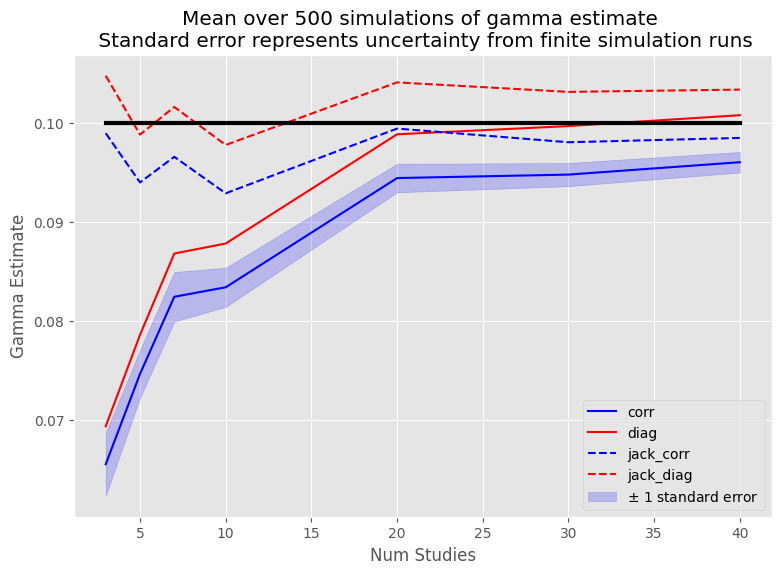

In [30]:
plt.figure(figsize=(9,6))
plt.plot(sim_results_corr.mean(),label = 'corr',c='blue')
plt.plot(sim_results_diag.mean(),label = 'diag',c='red')

plt.plot(sim_results_jack_corr.mean(),label = 'jack_corr',c='blue',ls = '--')
plt.plot(sim_results_jack_diag.mean(),label = 'jack_diag',c='red',ls = '--')


plt.fill_between(
    study_counts,
    sim_results_corr.mean()+sim_results_corr.sem(),
    sim_results_corr.mean()-sim_results_corr.sem(),
    color = 'blue',alpha=0.2,
    label = '$\\pm$ 1 standard error'
    )

plt.legend()
plt.plot([study_counts[0],study_counts[-1]],[gamma_true,gamma_true],c='black',lw = 3,label = 'Truth')
plt.title("Mean over 500 simulations of gamma estimate \n Standard error represents uncertainty from finite simulation runs")
plt.xlabel("Num Studies")
plt.ylabel("Gamma Estimate")

Text(0, 0.5, 'Gamma Estimate')

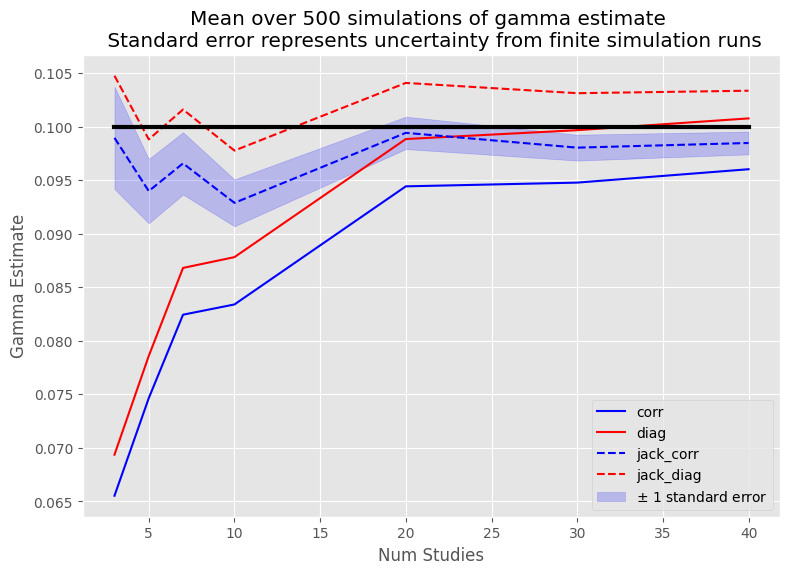

In [54]:
plt.figure(figsize=(9,6))
plt.plot(sim_results_corr.mean(),label = 'corr',c='blue')
plt.plot(sim_results_diag.mean(),label = 'diag',c='red')

plt.plot(sim_results_jack_corr.mean(),label = 'jack_corr',c='blue',ls = '--')
plt.plot(sim_results_jack_diag.mean(),label = 'jack_diag',c='red',ls = '--')


plt.fill_between(
    study_counts,
    sim_results_jack_corr.mean()+sim_results_jack_corr.sem(),
    sim_results_jack_corr.mean()-sim_results_jack_corr.sem(),
    color = 'blue',alpha=0.2,
    label = '$\\pm$ 1 standard error'
    )

plt.legend()
plt.plot([study_counts[0],study_counts[-1]],[gamma_true,gamma_true],c='black',lw = 3,label = 'Truth')
plt.title("Mean over 500 simulations of gamma estimate \n Standard error represents uncertainty from finite simulation runs")
plt.xlabel("Num Studies")
plt.ylabel("Gamma Estimate")

Text(0.5, 1.0, 'Estimates of bias')

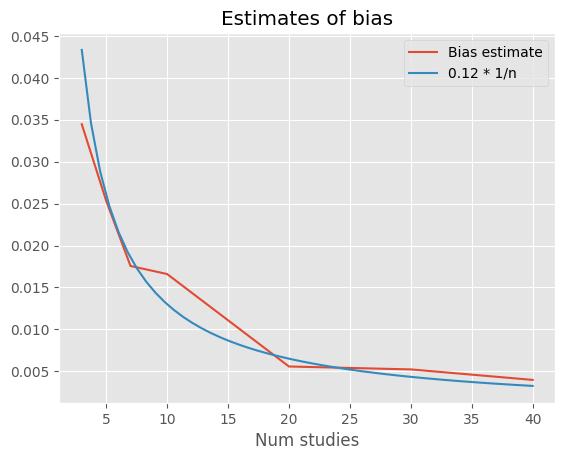

In [53]:
plt.plot(0.1 - sim_results_corr.mean(),label = "Bias estimate")
plt.plot(jnp.linspace(3,40),0.13 * 1/jnp.linspace(3,40),label = '0.12 * 1/n')
plt.legend()
plt.xlabel("Num studies")
plt.title("Estimates of bias")

Text(0, 0.5, 'Bias')

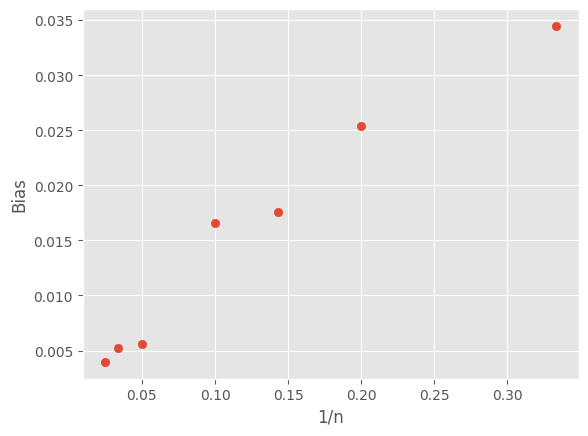

In [52]:
plt.scatter(1/jnp.array(study_counts),0.1 - sim_results_corr.mean(),label = "Bias estimate")
plt.xlabel("1/n")
plt.ylabel("Bias")